In [39]:
# 使用sklearn的函数来获取MNIST数据集
from sklearn.datasets import fetch_openml
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 为了显示中文
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

到目前为止，我们已经探讨了不同机器学习的模型，但是它们各自的训练算法在很大整度上还是一个黑匣子，同顾前几章里的部分案例，你大概感到非常惊讶，在对系统内部一无所知的情况下，居然已经实现了这么多:优化了一个回归系统，改进了一个数字图片分类器，从零开始构建了一个垃圾邮件分类器---所有这些，你都不知道它们实际是如何工作的。确实是这样，在许多情况下，你并不需要了解实施细节。

但是，能很好地理解系统如何工作也是非常有帮助的。针对你的任务，它有助于快速定位到合适的模型，正确的训练算法，以及一套适当的超参数。不仅如此，后期还能让你更高效地执行错误调试和错误分析。最后还要强调一点，本章探讨的大部分主题对于理解，构建和训练神经网络(本书第二部分)是至关重要的。

本章我们将从最简单的模型之一——线性回归模型，开始介绍两种非常不同的训练模型的方法:

* 通过“闲式”方程一直接计算出最适合训练集的模型参数(也就是使训练集上的成本函数最小化的模型参数)(最小二乘法)
* 使用迭代优化的方法，即梯度下降(GD), 逐渐调整模型参数直至训练集上的成本函数调至最低，最终趋同于第一种方法计算出来的模型参数。我们还会研究几个梯度下降的变体，包括批量梯度下降、小批量梯度下降以及随机梯度下降。等我们进入第二部分神经网络的学习时，会频繁地使用这几个变体。

接着我们会进入多项式回归的讨论，这是一个更为复杂的模型，更适合非线性数据集。由于该模型参数比线性模型更多，因此更容易造成对训练数据过度拟合，我们将学习使用学习曲线来分辨这种情况是否发生。然后，再介绍几种正则化技巧，降低过拟合训练数据的风险。

最后，我们将学习两种经常用于分类任务的模型：Logistic回归和Softmax回归

# 线性回归

在第一章，我们学过一个简单的生活满意度预测的例子:
$$life\_satisfaction=\theta_0+\theta_1\times GDP\_per\_capita$$

概括而言，线性模型就是对输入特征加权求和，再加上一个我们称为偏置项(也称为截距项)的常数

线性回归公式
$$\hat{y}=\theta_0+\theta_1x_1+\theta_2x_2+...+\theta_nx_n$$

向量化：
$$\hat{y}=h_{\theta}(X)=\theta^T\cdot X$$

回归模型的MSE成本函数：
$$MSE(X,h_\theta)=\frac{1}{m}\sum_{i=1}^{m}(\theta^T\cdot X^{i}-y^{i})^2$$

## 标准方程

求解成本函数最小的参数的解方法:
$$\hat{\theta}=(X^T\cdot X)^{-1}\cdot X^T \cdot y$$

In [40]:
#测试
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

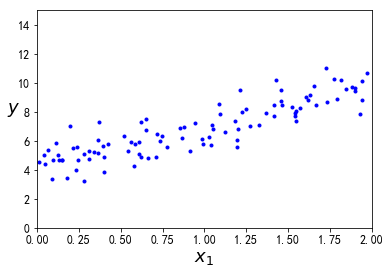

In [41]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [42]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [43]:
X[0],X_b[0]

(array([0.74908024]), array([1.        , 0.74908024]))

In [44]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [45]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

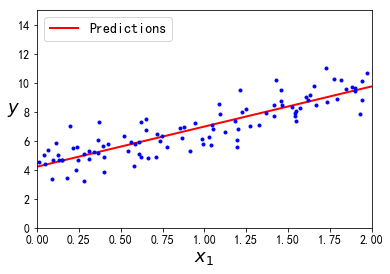

In [46]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [47]:
# 对比线性回归模型
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [48]:
y_predict=lin_reg.predict(X_new)

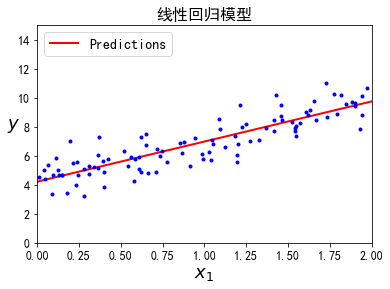

In [49]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.title("线性回归模型",fontsize=16)
plt.axis([0, 2, 0, 15])
plt.show()

In [50]:
# 使用最小二乘 库函数直接求解
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [51]:
# 先求伪逆，再直接点乘y，同样是最小二乘法
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 计算复杂度

第一种，标准方程求逆的时间复杂度通常为O(n^2.4)-O(n^3)之间，换句话，如果特征翻倍，计算时间会乘以5.3-8之间。
<br>最小二乘法基于伪逆，速度快一些O(n^2)
<br>好消息是，计算完成以后，预测就会非常快，线性的

接下来，我们来看几个截然不同的算法线性回归模型的训练方法，这些方法适合特征数或者训练示例大到内存无法满足要求的场景。

# 梯度下降

梯度下降是非常常用的优化算法，能够为大范围的问题找到最优解，可以类比迷失在浓雾的山上想下山。
<br>具体而言，通过测量参数相关的误差函数的局部梯度，并不断沿着降低梯度的方向调整，直到梯度降为0，到达最小值。
<br>梯度下降每一个重要参数的每一步的步长，这取决于超参数学习率。
<br>最后，并不是所有的成本函数都像碗，有的可能像洞，像其他各种不规则的地形，导致模型难以收敛。

梯度下降算法的两个主要挑战，一个是局部最小值，另一个是高原地区需要很长时间才能越过
<br>不过线性回归模型的MSE成本函数是凸函数，这意味着任意两点的线段永远不会和曲线相交，也就是不存在局部最小，只有全局最小值。它同时也是一个连续函数，所以斜率不会发生陡峭的变化。
<br>这两件事情保证的结论是：即便是乱走，梯度下降算法都可以趋近于全局最小值(只要等待足够长的时间，学习率也不要太高）

不过成本函数虽然是碗状的，不同特征的尺寸差别巨大，可能是细长的碗。这样收敛会更慢。
<br>因此应用梯度下降算法时，需要保证所有的特征值的大小比例都差不多，比如使用标准化，否则收敛的时间会长很多。

训练模型，就是搜寻使成本函数(在训练集上)最小化的参数组合，这是模型参数空间层面上的搜索：模型的参数越多，这个空间的维度就越多，搜索也越难。

## 批量梯度下降

简而言之，就是询问，当我们下山的时候，脚下的斜率是多少
$$
\frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T\cdot x^{i}-y^{i})x_j^{i}
$$

需要注意的是，批量梯度下降，每一次都使用全部数据，故而数据量越多，速度越慢。但是算法，在随特征数据扩展的表现比较好。如果训练数据有几十万特征，那么梯度下降要比标准方程要快得多。

In [52]:
eta=0.1
n_iterations=1000
m=100
theta=np.random.randn(2,1)
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta=theta-eta*gradients
theta

array([[4.21509616],
       [2.77011339]])

In [53]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [54]:
theta_path_bgd=[]
def plot_gradient_descent(theta,eta,theta_path=None):
    m=len(X_b)
    plt.plot(X,y,'b.')
    n_iterations=1000
    for iteration in range(n_iterations):
        if iteration<10:
            y_predict=X_new_b.dot(theta)
            style="b-" if iteration > 0 else 'r--'
            plt.plot(X_new,y_predict,style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
        theta=theta-eta*gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$",fontsize=18)
    plt.axis([0,2,0,15])
    plt.title(r"$\eta={}$".format(eta),fontsize=16)

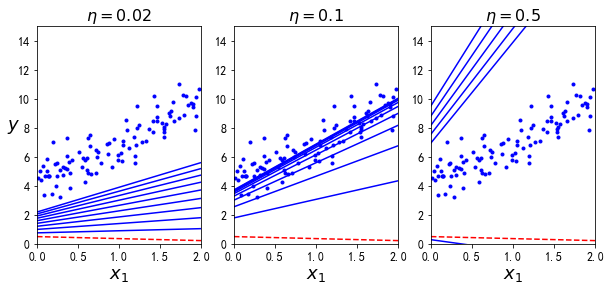

In [55]:
np.random.seed(42)
theta=np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131);plot_gradient_descent(theta,eta=0.02)
plt.ylabel("$y$",rotation=0,fontsize=18)
plt.subplot(132);plot_gradient_descent(theta,eta=0.1,theta_path=theta_path_bgd)
plt.subplot(133);plot_gradient_descent(theta,eta=0.5)
plt.show()

## 随机梯度下降

随机梯度下降每一步会随机选择一个实例来计算梯度，也因此，每一轮迭代会很不规则，而且即使到了最小值，也依旧会持续反弹，永远无法收敛。但是好处是可以跳出局部最小值。
<br>因此，随机性的好处是可以逃离局部最小值，缺点是永远定位不出最小值。要解决这个问题，可以采用逐步降低学习率，这个过程又叫作模拟退火。

In [58]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

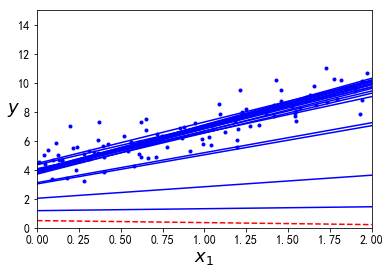

In [59]:
n_epochs=50
t0,t1=5,50

def learning_shcedule(t):
    return t0/(t+t1)

theta=np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch==0 and i<20:
            y_predict=X_new_b.dot(theta)
            style='b-' if i>0 else 'r--'
            plt.plot(X_new,y_predict,style)
        random_index=np.random.randint(m)
        xi=X_b[random_index:random_index+1]
        yi=y[random_index:random_index+1]
        gradients=2*xi.T.dot(xi.dot(theta)-yi)
        eta=learning_shcedule(epoch*m+i)
        theta=theta-eta*gradients
        theta_path_sgd.append(theta)
    
plt.plot(X,y,"b.")
plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$y$',rotation=0,fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [19]:
theta

array([[4.21076011],
       [2.74856079]])

In [20]:
# sklearn的api函数
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16782089]), array([2.72603052]))

## 小批量梯度下降

小批量梯度下降算法介于批量梯度下降算法和随机梯度下降算法之间。小批量梯度下降算法的优势在于可以从矩阵运算的硬件优化中获得显著的性能提升，特别是需要用到GPU时。
<br>该算法会比随机的要稳定，但也可能更难从局部最小值逃脱

In [22]:
theta_path_mgd=[]
n_iterations=50
minibatch_size=20
np.random.seed(42)
theta=np.random.randn(2,1)

t0,t1=200,1000
def learning_schedule(t):
    return t0/(t+t1)

t=0
for eopch in range(n_iterations):
    shuffled_indices=np.random.permutation(m)
    X_b_shuffled=X_b[shuffled_indices]
    y_shuffled=y[shuffled_indices]
    for i in range(0,m,minibatch_size):
        t+=1
        xi=X_b_shuffled[i:i+minibatch_size]
        yi=y_shuffled[i:i+minibatch_size]
        gradients=2/minibatch_size*xi.T.dot(xi.dot(theta)-yi)
        eta=learning_schedule(t)
        theta=theta-eta*gradients
        theta_path_mgd.append(theta)

In [23]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [24]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

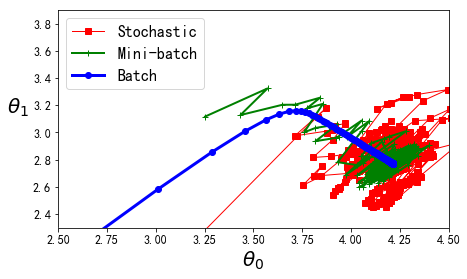

In [25]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

|算法|实例特征维数m很大|是否支持核外|实例个数n很大|超参数|是否需要缩放|sklearn|
|-|-|-|-|-|-|-|
|标准方程|快|否|慢|0|否|Linear Regression|
|批量梯度下降算法|慢|否|快|2|是|n/a|
|随机梯度下降算法|快|是|快|>=2|是|SGDRegerssor|
|小批量梯度下降算法|快|是|快|>=2|是|n/a|

# 多项式回归

如果数据比简单的线性更加复杂，我们也可以用线性模型来拟合，只需要给每个特征添加一个新特征，然后用扩展后的新特征来训练。

In [60]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [61]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

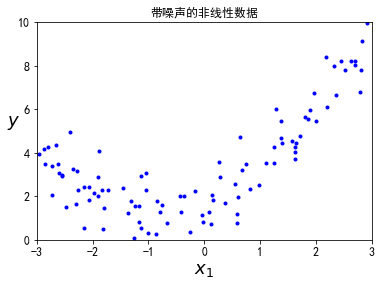

In [62]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title("带噪声的非线性数据")
plt.axis([-3, 3, 0, 10])
plt.show()

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [66]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_polt包含原本的特征X和该特征的平方，然后用这个扩展后的训练集匹配线性回归模型

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

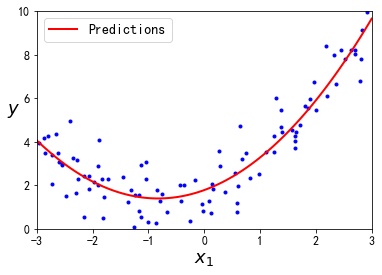

In [32]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

PolynomialFeatures(degree=d)可以将包含n个特征的数组转换为包含$\frac{n+d}{d!n!}$个特征的数组，要小心特征组合的数量爆炸。

# 学习曲线

使用更高阶的多项式虽然可能比简单的线性回归要好，但显然也更容易过度拟合。检查是否过度拟合，我们可以采用交叉验证，这里也可以采用学习曲线。

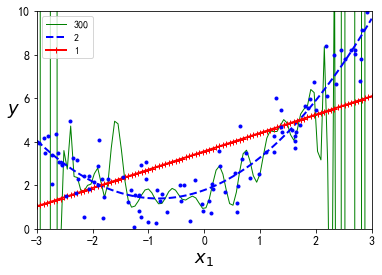

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

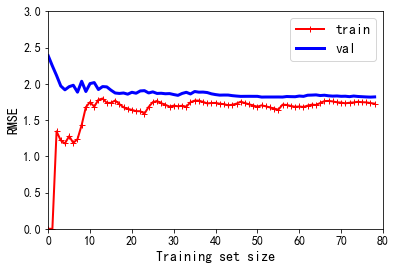

In [35]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

* 两条曲线靠的很近
* 误差停留在高地
这就是典型的拟合不足

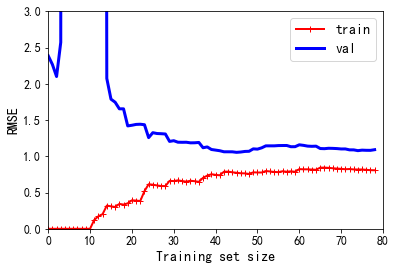

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

* 训练数据的误差低于线性回归模型
* 两条曲线之间有一定的差距
<br>这是典型过度拟合的标志，如果数据越多，那么二者之间的差距也会来越靠近

# 正则线性模型

减少模型过拟合的一个好办法是对模型正则化。
<br>对于多项式模型，简单办法就是降低多项式的阶数
<br>下面将会使用Ridge回归、Lasson回归、、Elastic网络三种方法来对权重进行约束

## 岭回归

岭回归是线性回归的正则化版，通过在成本函数中添加一个等于$$\alpha\sum_{i=1}^{n}\theta_i^2$$的正则项

<b>需要注意的是，正则项只能在训练的时候添加到损失函数中，一旦训练完成，需要使用未经正则化的性能指标来评估模型性能。<b>

$$J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^{n}\theta_i^2$$

执行岭回归前，必须对数据做特征缩放，因为其对于输入特征的大小非常敏感

In [44]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

我们可以看到 l2正则后的结果会更平坦，更合理。

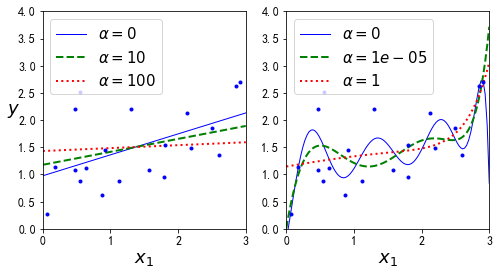

In [45]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

闭式解方法:
$$\hat{\theta}=(X^T\cdot X + \alpha A)^{-1}\cdot X^T\cdot y$$

In [39]:
# 使用cholesky矩阵因式分解法
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [40]:
# 使用随机梯度下降
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.49905184])

In [41]:
# sag 随机平均梯度下降
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

## 套索回归

又叫做最小绝对收缩和选择算子回归

$$J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^{n}|\theta_i|$$

Lasso回归的一个重要特点是它倾向于完全消除掉最不重要特征的权重，也就是将其设为0。话句话说，Lasso会自动做特征选择，并输出一个系数模型。我可以看到l1正则后的多项式曲线更接近于二次函数。

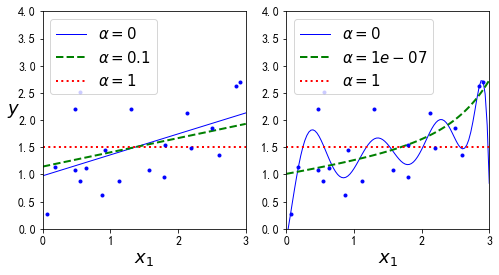

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [46]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

可视化L1和L2正则化的梯度下降的差异

In [51]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

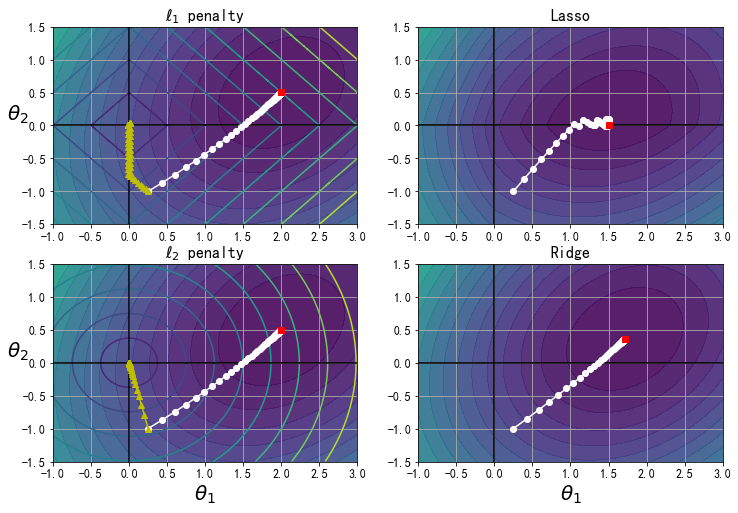

In [53]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
plt.show()

## 弹性网络

介于L2和L1之间就是Elastic回归
$$J(\theta)=MSE(\theta)+r\alpha\sum_{i=1}^{n}|\theta_i|+\frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_i^2$$

In [47]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

这么多的正则化方式，该如何取舍呢？通常来说，有正则化，哪怕是很小，也更可取。故大多数情况要避免使用纯线性回归。岭回归就是一个不错的默认选择，但是如果实际应用的特征只有少数几个，那么应该更倾向于Lasso或者Elastic，因为这两个会将无用特征的权重降为0.一般而言，Elastic会优于Lasso，因为当特征数量超过训练实例数量，又或者是几个特征强相关时，Lasso回归的表现可能非常不稳定。

## 早期停止法

对于梯度下降算法，还有早期停止法这一与众不同的正则化方法，就是在验证集误差达到最小的时候停止训练。

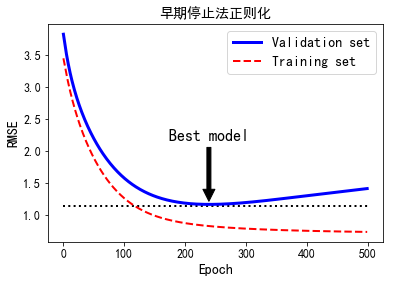

In [48]:
# 定义训练数据
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])
# 用多项式来扩展训练数据，采用90阶多项式来组合，然后标准化
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
# 随机梯度下降算法
sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
# 迭代500轮
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])
# 打印文本标记
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.title("早期停止法正则化", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [50]:
# 打印训练集最佳的迭代轮数和此时的模型
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

## 逻辑回归

正如第一章提到的，一些回归算法也可以用于分类，反之亦然。逻辑回归就是被广泛用于估算一个实例属于某个特定类别的概率。如果估算概率超过50%就是属于该类，反之则不是。

## 概率估算

逻辑回归模型概率估算:
$$\hat{p}=h_\theta(x)=\sigma(\theta^T\cdot x)$$

逻辑函数：
$$\sigma(t)=\frac{1}{1+exp(-t)}$$

预测模型：
$$\hat{y}=
\begin{cases}
0 & (\hat{p}<0.5)\\
1 & (\hat{p}\geq0.5)
\end{cases}$$

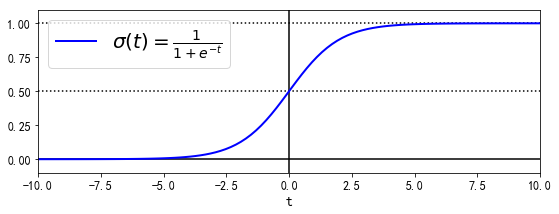

In [54]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

## 训练和成本函数

单个训练实例的损失函数:
$$c(\theta)=
\begin{cases}
-log(\hat{p}) & (y=1)\\
-log(1-\hat{p}) & (y=0)
\end{cases}$$

我们可以看到，当p接近于0的时候，-log(p)会变得非常大，所以如果模型估算一个正实例的概率接近于0，那么损失函数就会非常高，反过来，当p接近于1的时候，-log(p)接近于0，所以对一个负类实例估算出的概率接近于0，损失函数也会很低。

逻辑回归成本函数:
$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)})+(1-y^{(i)})log(1-\hat{p}^{(i)})]$$

坏消息是，这个函数没有已知的闭式方程(也就是不尊在一个标准方差的等价方程)。好消息，这是个凸函数，通过梯度下降算法保证能够找出全局最小值。

Logistic损失函数的偏导数:
$$\frac{\partial}{\partial\theta_j}J(\theta)=\frac{1}{m}\sum_{i=1}^{m}(\sigma(\theta^T \cdot x^{(i)})-y^{(i)})x_j^{(i)}$$

$$\frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^T\cdot x^{i}-y^{i})x_j^{i}$$

## 决策边界

我们下面用鸢尾花数据来说明逻辑回归，该数据集是非常著名的数据，共有150朵花的三个类别的萼片和花瓣的长度和宽度数据。

In [56]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [57]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [58]:
# 做二分类，只取出花瓣宽度数据做分类
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

In [59]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

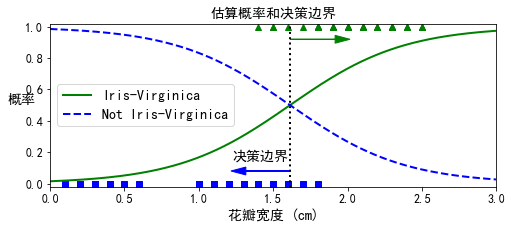

In [73]:
# 打表 0-3 1000个值
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
# 进行预测
y_proba = log_reg.predict_proba(X_new)
# 取出大于0.5的临界值
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
# 鸢尾花数据
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
#打印决策面
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
# 打印两条曲线
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
# 打印决策面
plt.text(decision_boundary-0.2, 0.15, "决策边界", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.title('估算概率和决策边界', fontsize=14)
plt.xlabel("花瓣宽度 (cm)", fontsize=14)
plt.ylabel("概率", fontsize=14,rotation=0)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
# 取出花瓣长度和宽度做二分类
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

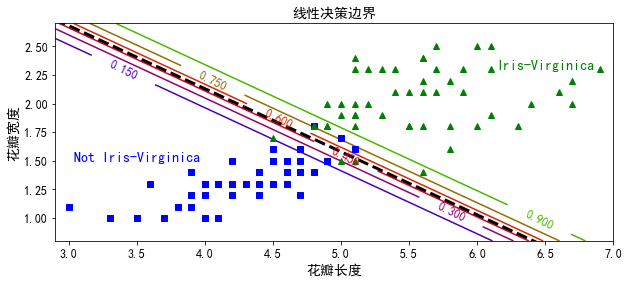

In [75]:
# liblinear 用于做二分类，计算出线性边界
log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.title('线性决策边界', fontsize=14)
plt.xlabel("花瓣长度", fontsize=14)
plt.ylabel("花瓣宽度", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

与其他线性模型一样，逻辑回归模型可以用l1和l2惩罚函数来正则化，sklearn默认添加的是l2函数。不过在LogisticRegression不是alpha，而是C，C越高，模型正则化程度越高。

## Softmax回归

对逻辑回归模型做推广，可以支持多个类别了。
<br>原理很简单，对于一个给定的实例x,Softmax回归模型首先计算出每个类别k的分类S_k(x)，然后对这些分数应用softmax函数(又叫做归一化指数),估算出每个类别的概率。
<br>类别Softmax分数:
$$s_k(x)=\theta_k^T\cdot x$$

Softmax函数:
$$\hat{p}_k=\sigma(s(x))_k=\frac{exp(s_k(x))}{\sum_{j=1}^{K}exp(s_j(x))}$$

Softmax回归分类器的预测：
$$\hat{y}=\underset{k}{argmax}\sigma(s(x))_k=\underset{k}{argmax}s_k(x)=\underset{k}{argmax}(\theta_k^T \cdot x)$$

交叉熵成本函数:
$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat{p}_k^{(i)})$$

交叉熵衡量每个预测概率分类的平均比特数，如果预测完美，则结果等于源数据本身的熵(也就是本身固有的不可预测性)，但是如果预测有误，则交叉熵会变大，增大的部分又称为KL散度。两个概率分布p和q之间的交叉熵可以定义为：
$$H(p,q)=-\sum_xp(x)logq(x)$$

对于类别k的交叉熵梯度向量:
$$\Delta_{\theta k}J(\Theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}_k^{(i)}-y_k^{(i)})x^{(i)}$$

In [76]:
# 取两个特征作三分类
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

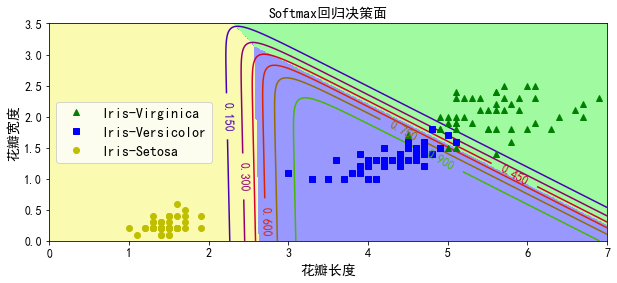

In [80]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.title("Softmax回归决策面", fontsize=14)
plt.xlabel("花瓣长度", fontsize=14)
plt.ylabel("花瓣宽度", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [81]:
softmax_reg.predict([[5, 2]])

array([2])

In [82]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# 练习

## 使用Softmax回归做批量梯度下降训练，并实施早期停止法

In [83]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

In [84]:
X[0]

array([1.4, 0.2])

In [85]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [86]:
X_with_bias[0]

array([1. , 1.4, 0.2])

In [87]:
np.random.seed(2042)
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)
# 2 2 6 切分为测试集 验证集 训练集
test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [88]:
len(X_train),len(y_train),len(X_valid),len(y_valid),len(X_test),len(y_test)

(90, 90, 30, 30, 30, 30)

In [89]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [90]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [91]:
# 1=>onehot
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [92]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [93]:
# 定义我们自己的softmax函数
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [94]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [95]:
# 最原始梯度下降
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

# 随机生成参数，按照输入维度和输出维度
Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    # 交叉熵函数
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.4106007142918712
5000 0.3956780375390374


In [96]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

In [97]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

In [104]:
# 添加l2正则
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    # l2正则
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.038280239064085
500 0.5322201822520979
1000 0.5035315271928776
1500 0.49465903889629925
2000 0.49128501840330063
2500 0.48989424824341127
3000 0.489296880123749
3500 0.4890341569337251
4000 0.4889169279611998
4500 0.4888641374714865
5000 0.488840222941224


In [105]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

In [107]:
# 添加早期停止
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients
    
    # 梯度下降完，再预测一下，看一下验证集上面的表现
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    # 添加早期停止
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 2.897275838876366
500 0.5702751662442892
1000 0.5425654873413586
1500 0.5353090385301479
2000 0.5331256731252507
2500 0.5325827330917429
2736 0.5325454243382794
2737 0.532545425210158 early stopping!


In [108]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

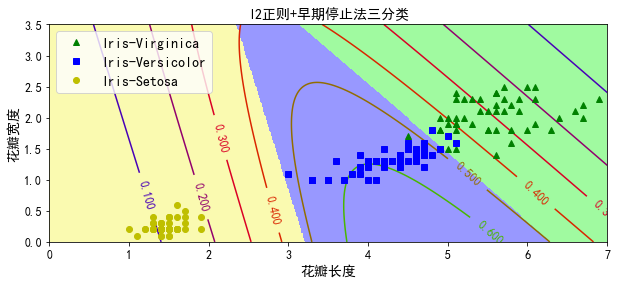

In [112]:
# 可视化
# 打表
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
# 拼凑x
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]
# 预测打表的x
logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)
# 对获得的进行涂色
zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
# 画上数据点
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

# 涂上颜色
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 画上等高线
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.title("l2正则+早期停止法三分类", fontsize=14)
plt.xlabel("花瓣长度", fontsize=14)
plt.ylabel("花瓣宽度", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [110]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333